## ****Import Modules****


In [1]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model 
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [2]:
BASE_DIR = '/kaggle/input/flickr8k'
WORKING_DIR = '/kaggle/working'

In [3]:
model = VGG16()
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
print(model.summary())

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [4]:
features = {}
directory = os.path.join(BASE_DIR, 'images')

for img_name in tqdm(os.listdir(directory)):
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224,224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    feature = model.predict(image,verbose=0)
    image_id = img_name.split('.')[0]
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [5]:
pickle.dump(features, open(os.path.join(WORKING_DIR,'features.pkl'),'wb'))

In [6]:
#load features from pickle
with open(os.path.join(WORKING_DIR,'features.pkl'),'rb') as f:
    features = pickle.load(f)

In [7]:
with open(os.path.join(BASE_DIR,'captions.txt'), 'r') as f:
    next(f)
    caption_doc = f.read()
    

In [8]:
#create mapping of image to captions
mapping = {}
for line in tqdm(caption_doc.split('\n')):
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    #remove extension from img id
    image_id = image_id.split('.')[0]
    #convert caption list to string
    caption = " ".join(caption)
    if image_id not in mapping:
        mapping[image_id]=[]
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [9]:
len(mapping)

8091

# ****Preprocess Text Data****


In [10]:
def clean(mapping):
    for key,captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            #pre-processing steps
            caption = caption.lower()
            caption = caption.replace('[^A-Za-z]','')
            caption = caption.replace('\s+', ' ')
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [11]:
#before pre-process
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [12]:
#preprocess the text
clean(mapping)

In [13]:
#preprocessed txt for a single id
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [14]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [15]:
len(all_captions)

40455

In [16]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [17]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index)+1

In [18]:
vocab_size

8485

In [19]:
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

# Train Test Split

In [20]:
image_ids = list(mapping.keys())
split = int(len(image_ids)*0.90)
train = image_ids[:split]
test = image_ids[split:]

In [21]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0

    while True:  # Infinite loop for generator
        for key in data_keys:
            captions = mapping[key]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]  # Fixed method name
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length, padding="post")[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    X1.append(features[key][0])  # Image features
                    X2.append(in_seq)  # Text sequence
                    y.append(out_seq)  # One-hot encoded next word

            n += 1
            if n == batch_size:  # Yield when batch size is met
                yield (np.array(X1), np.array(X2)), np.array(y)  # ✅ Return tuple
                X1, X2, y = list(), list(), list()
                n = 0

        # Ensure all remaining data is yielded at the end
        if len(X1) > 0:
            yield (np.array(X1), np.array(X2)), np.array(y)  # ✅ Return tuple
            X1, X2, y = list(), list(), list()
            n = 0


# **MODEL CREATION**

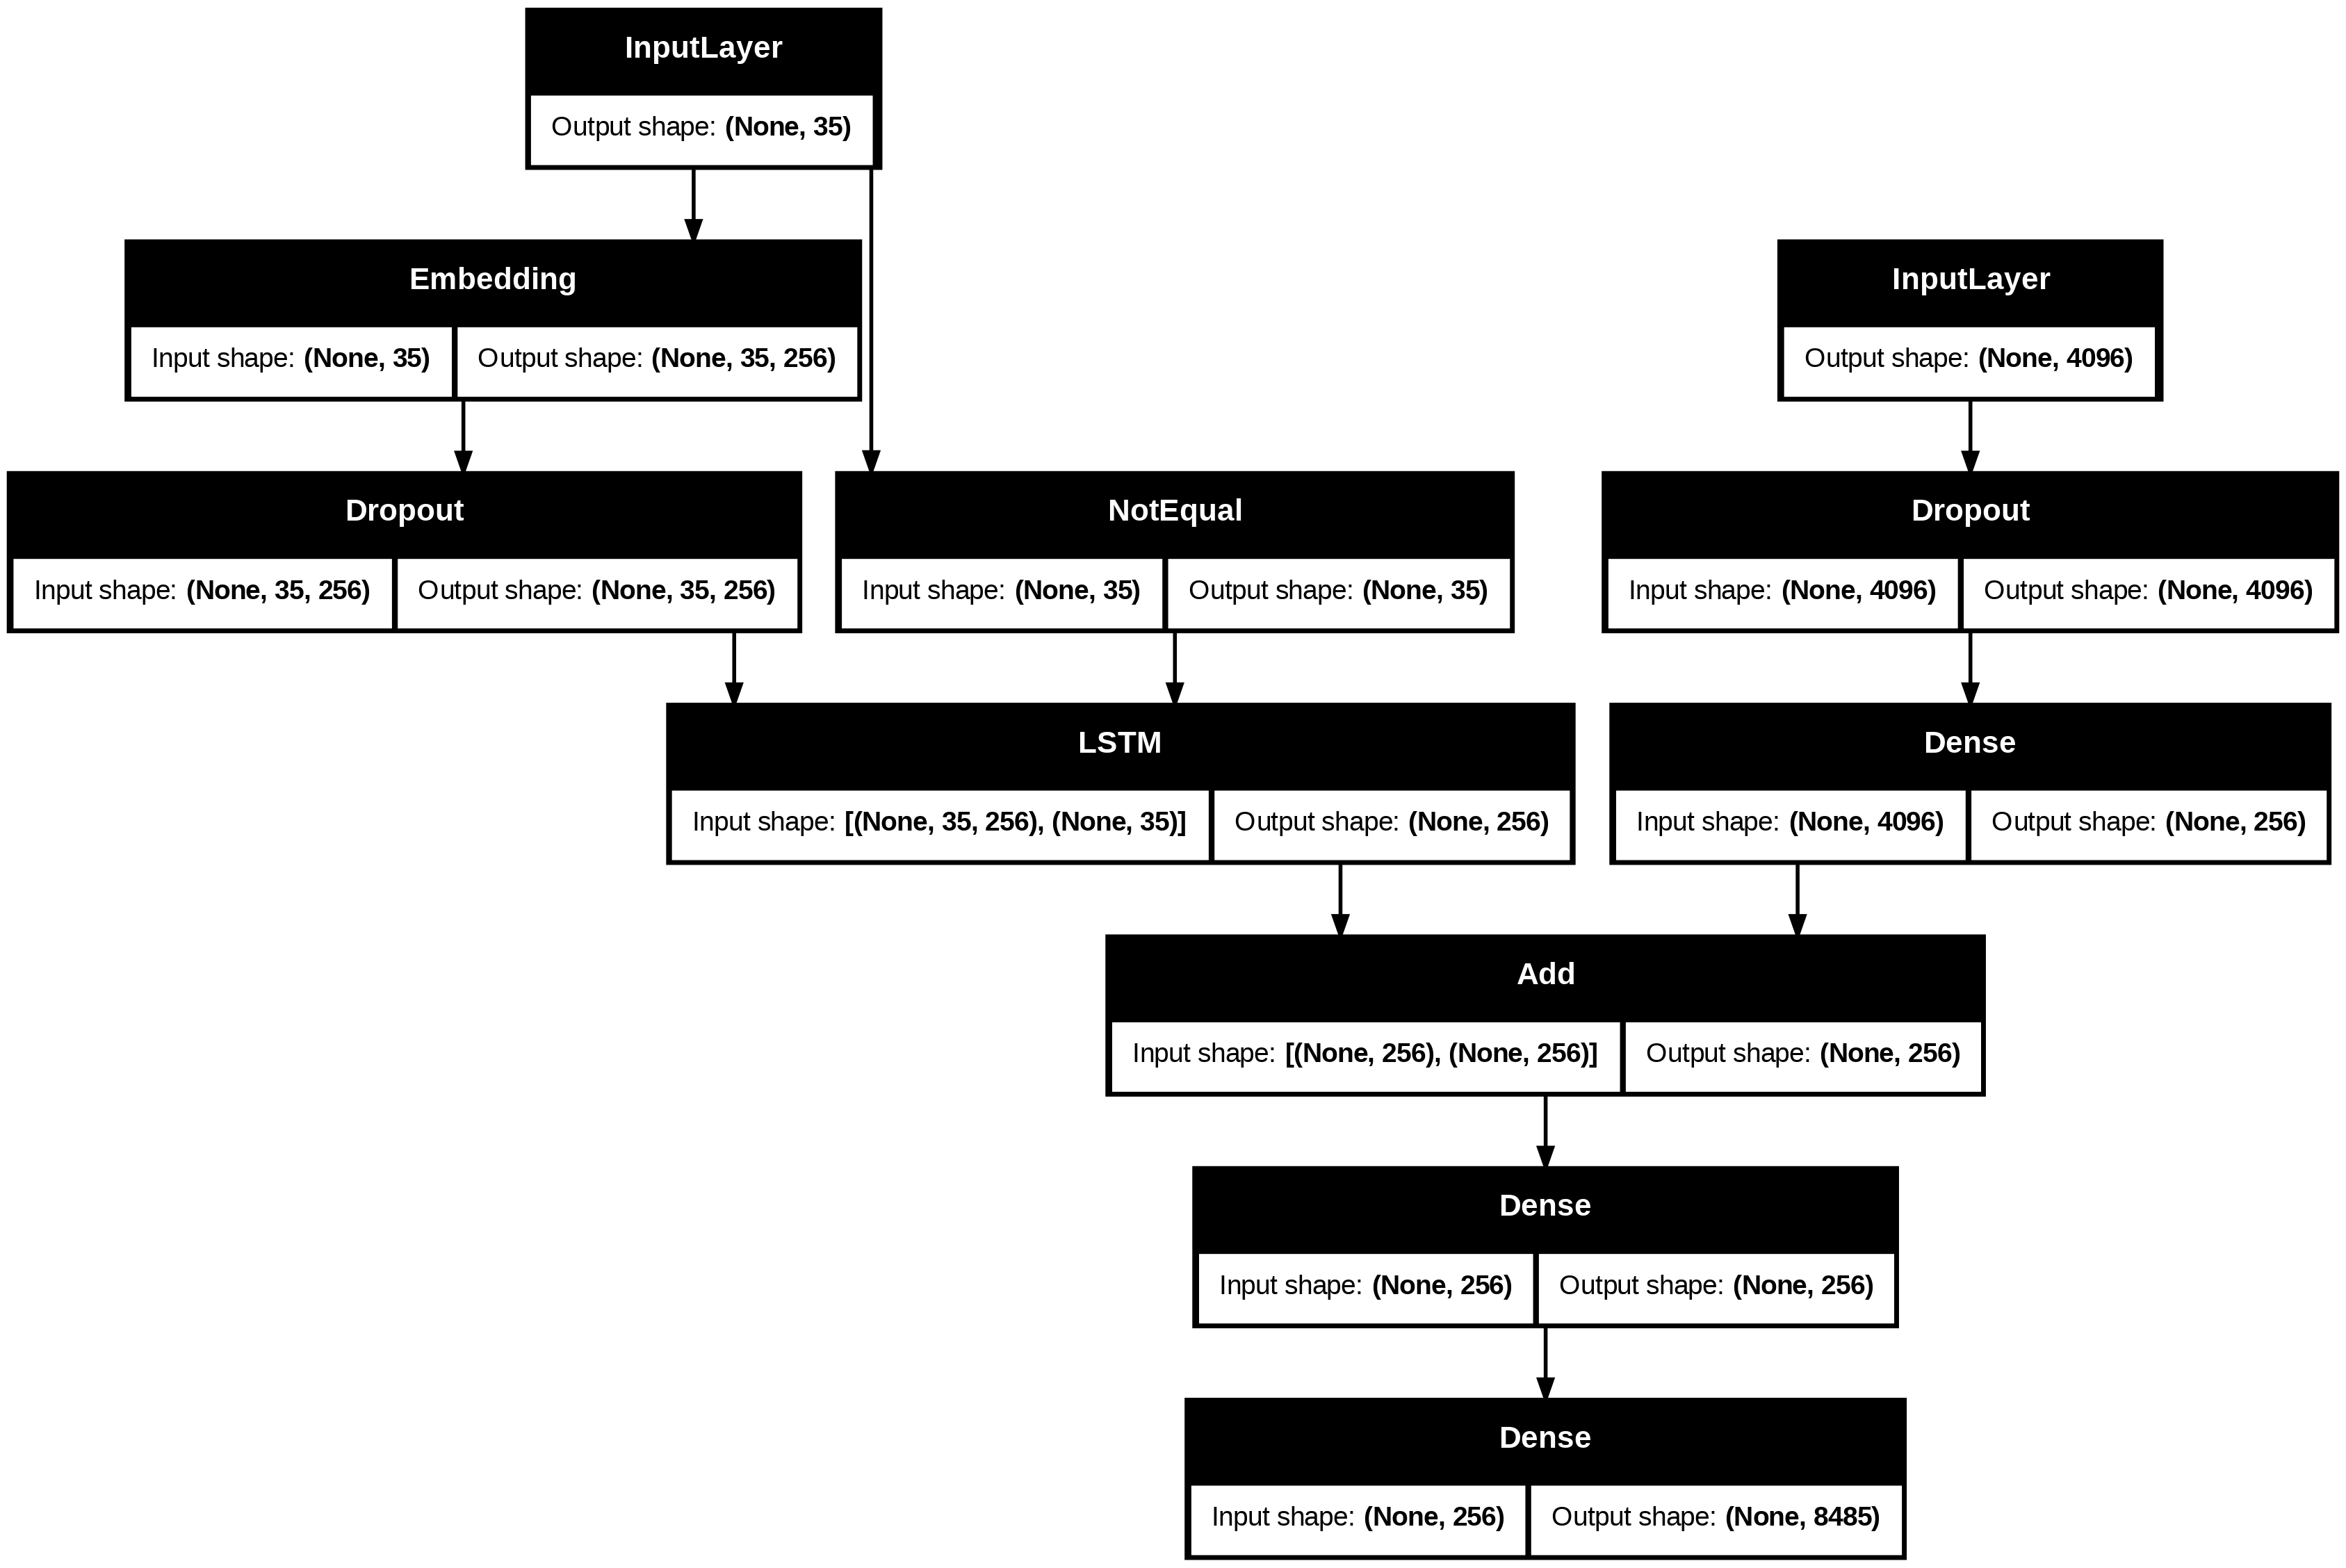

In [22]:
#encoding
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size,256,mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

#decoding
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation = 'relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss = 'categorical_crossentropy',optimizer='adam')
plot_model(model, show_shapes=True)


In [23]:
epochs = 5
batch_size = 64
steps = (len(train) + batch_size - 1) // batch_size  # Ensure all samples are processed

for i in range(epochs):
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)


114/114 ━━━━━━━━━━━━━━━━━━━━ 625s 5s/step - loss: 6.1747
114/114 ━━━━━━━━━━━━━━━━━━━━ 650s 6s/step - loss: 4.4756
114/114 ━━━━━━━━━━━━━━━━━━━━ 708s 6s/step - loss: 3.7978
114/114 ━━━━━━━━━━━━━━━━━━━━ 685s 6s/step - loss: 3.4888
114/114 ━━━━━━━━━━━━━━━━━━━━ 705s 6s/step - loss: 3.2756


In [24]:
model.save(WORKING_DIR+'/best_model.h5')

In [25]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
        return None

In [26]:


def predict_caption(model, image, tokenizer, max_length):
    in_text = "startseq"
    
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)  # ✅ Fixed function name
        
        yhat = model.predict([image, sequence], verbose=0)  # ✅ Fixed typo in verbose
        yhat = np.argmax(yhat)  # ✅ Pass model output to np.argmax()
        
        word = tokenizer.index_word.get(yhat, None)
        if word is None:
            break
            
        in_text += " " + word
        if word == "end":
            break

    return in_text


In [27]:
from nltk.translate.bleu_score import corpus_bleu
actual, predicted = list(), list()

for key in tqdm(test):
    captions = mapping[key]
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()  # ✅ Fixed typo

    actual.append(actual_captions)
    predicted.append(y_pred)  # ✅ Removed extra `.split()`

# Compute BLEU scores
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))  # ✅ Fixed function name
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))  # ✅ Correct label


  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.175069
BLEU-2: 0.103449


In [28]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    #image_name = "1007320043_627395c3d8.jpg"
    image_id= image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------ACTUAL-------------------------')
    for caption in captions:
        print(caption)
    y_pred = predict_caption(model, features[image_id],tokenizer,max_length)
    print('---------------------Predicted-------------------------')
    print(y_pred)
    plt.imshow(image)

---------------------ACTUAL-------------------------
startseq man in hat is displaying pictures next to skier in blue hat endseq
startseq man skis past another man displaying paintings in the snow endseq
startseq person wearing skis looking at framed pictures set up in the snow endseq
startseq skier looks at framed pictures in the snow next to trees endseq
startseq man on skis looking at artwork for sale in the snow endseq
---------------------Predicted-------------------------
startseq two hockey hockey players in the snow endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq


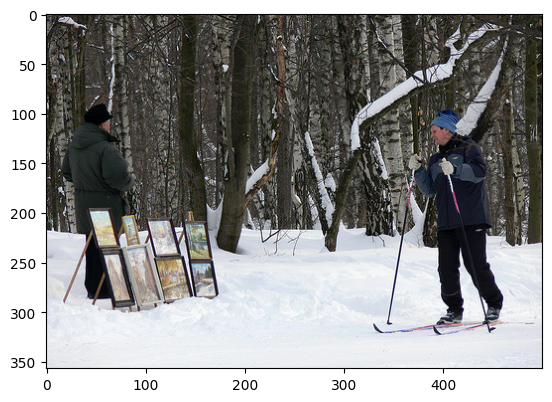

In [29]:
generate_caption("101669240_b2d3e7f17b.jpg")